In [48]:
import time, matplotlib, sklearn
# visualizatoin 
import matplotlib.pyplot as plt 
import seaborn as sns
# data wrangling
import pandas as pd
import numpy as np 
# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression


In [49]:
description = pd.read_csv('physionet.org/files/widsdatathon2020/1.0.0/data/WiDS_Datathon_2020_Dictionary.csv')
description_dict = description.set_index('Variable Name').to_dict(orient='index')

df = pd.read_csv('physionet.org/files/widsdatathon2020/1.0.0/data/training_v2.csv')

print(df.info())
summary_stats = df.describe(include="all")
summary_stats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB
None


,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
count,91713.000000,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,91713.000000,90318,91688,90379.000000,...,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90051,90051
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,10
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Caucasian,M,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cardiovascular,Cardiovascular
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70684,49469,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29999,38816
mean,65606.079280,65537.131464,105.669262,0.086302,62.309516,29.185818,0.183736,NaN,NaN,169.641588,...,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638,NaN,NaN
std,37795.088538,37811.252183,62.854406,0.280811,16.775119,8.275142,0.387271,NaN,NaN,10.795378,...,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169,NaN,NaN
min,1.000000,1.000000,2.000000,0.000000,16.000000,14.844926,0.000000,NaN,NaN,137.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,32852.000000,32830.000000,47.000000,0.000000,52.000000,23.641975,0.000000,NaN,NaN,162.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,65665.000000,65413.000000,109.000000,0.000000,65.000000,27.654655,0.000000,NaN,NaN,170.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,98342.000000,98298.000000,161.000000,0.000000,75.000000,32.930206,0.000000,NaN,NaN,177.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN


In [50]:
print("Missing Values:")
missing_values = df.isnull().sum().sort_values(ascending=False) 
missing_values

Missing Values:


h1_bilirubin_min    84619
h1_bilirubin_max    84619
h1_lactate_min      84369
h1_lactate_max      84369
h1_albumin_max      83824
                    ...  
icu_stay_type           0
icu_id                  0
encounter_id            0
hospital_death          0
patient_id              0
Length: 186, dtype: int64

### Removing Features With Missing Values

In [51]:
missing_percent = df.isnull().sum() * 100 / len(df)
columns_to_drop = missing_percent[missing_percent > 50].index
cleaned_df = df.drop(columns=columns_to_drop)


print(f"{len(cleaned_df.columns.tolist())} Remaining columns\n")
print(f"{len(columns_to_drop.tolist())} Columns removed:\n {columns_to_drop.tolist()}")

112 Remaining columns

74 Columns removed:
 ['albumin_apache', 'bilirubin_apache', 'fio2_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'urineoutput_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_mbp_invasive_max', 'h1_mbp_invasive_min', 'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'd1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max', 'd1_bilirubin_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max', 'd1_lactate_min', 'h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_bun_max', 'h1_bun_min', 'h1_calcium_max', 'h1_calcium_min', 'h1_creatinine_max', 'h1_creatinine_min', 'h1_glucose_max', 'h1_glucose_min', 'h1_hco3_max', 'h1_hco3_min', 'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_hematocrit_max', 'h1_hematocrit_min', 'h1_inr_max', 'h1_inr_min', 'h1_lactate_max',

In [52]:
median_imputer = SimpleImputer(strategy='median')  # We can change this to mean imputer as well
mode_imputer = SimpleImputer(strategy='most_frequent')

numerical_columns = cleaned_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = cleaned_df.select_dtypes(include=['object']).columns
categorical_columns

Index(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_stay_type', 'icu_type', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object')

In [53]:
imputed_df = cleaned_df.copy()
for column in numerical_columns:
    imputed_df[[column]] = median_imputer.fit_transform(imputed_df[[column]])

for column in categorical_columns:
    imputed_df[[column]] = mode_imputer.fit_transform(imputed_df[[column]])

In [54]:
missing_values = imputed_df.isnull().sum()
total_missing = missing_values.sum()

print("Missing values in each column:")
print(missing_values)
print("\nTotal missing values in the dataset:", total_missing)

if total_missing == 0:
    print("No missing values found. The dataset is ready for further analysis or modeling.")
else:
    print("There are still missing values in the dataset.")

Missing values in each column:
encounter_id                   0
patient_id                     0
hospital_id                    0
hospital_death                 0
age                            0
                              ..
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
apache_3j_bodysystem           0
apache_2_bodysystem            0
Length: 112, dtype: int64

Total missing values in the dataset: 0
No missing values found. The dataset is ready for further analysis or modeling.


### How Distribution is Affected from the Imputation

In [55]:
skewness_before = df[numerical_columns].apply(lambda x: x.skew())
skewness_after = imputed_df[numerical_columns].apply(lambda x: x.skew())

mean_before = df[numerical_columns].mean()
mean_after = imputed_df[numerical_columns].mean()

std_before = df[numerical_columns].std()
std_after = imputed_df[numerical_columns].std()

stats_comparison = pd.DataFrame({
    "Skewness Before": skewness_before,
    "Skewness After": skewness_after,
    "Mean Before": mean_before,
    "Mean After": mean_after,
    "Std Dev Before": std_before,
    "Std Dev After": std_after,
})

stats_comparison["Change in Skewness"] = np.abs(stats_comparison["Skewness After"] - stats_comparison["Skewness Before"])
stats_comparison["Change in Mean"] = np.abs(stats_comparison["Mean After"] - stats_comparison["Mean Before"])
stats_comparison["Change in Std Dev"] = np.abs(stats_comparison["Std Dev After"] - stats_comparison["Std Dev Before"])

stats_comparison_sorted = stats_comparison.sort_values(by=["Change in Skewness", "Change in Mean", "Change in Std Dev"], ascending=False)
stats_comparison_sorted

,Skewness Before,Skewness After,Mean Before,Mean After,Std Dev Before,Std Dev After,Change in Skewness,Change in Mean,Change in Std Dev
creatinine_apache,3.546544,4.065598,1.480014,1.377228,1.525787,1.374878,0.519054,0.102785,0.150909
bun_apache,2.129075,2.536929,25.825330,24.391842,20.672980,18.583370,0.407854,1.433488,2.089610
wbc_apache,1.678508,2.082826,12.133333,11.717316,6.917984,6.076176,0.404319,0.416017,0.841808
d1_creatinine_min,3.616993,3.880141,1.366947,1.320717,1.333855,1.264529,0.263148,0.046231,0.069326
d1_creatinine_max,3.597629,3.858945,1.488650,1.434469,1.506957,1.429217,0.261316,0.054181,0.077740
...,...,...,...,...,...,...,...,...,...
elective_surgery,1.633330,1.633330,0.183736,0.183736,0.387271,0.387271,0.000000,0.000000,0.000000
icu_id,-0.163940,-0.163940,508.357692,508.357692,228.989661,228.989661,0.000000,0.000000,0.000000
pre_icu_los_days,10.988615,10.988615,0.835766,0.835766,2.487756,2.487756,0.000000,0.000000,0.000000
readmission_status,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [56]:
df.to_csv('physionet.org/files/widsdatathon2020/1.0.0/data/cleaned_imputed_training_v2.csv', index=False)

In [57]:
numerical_columns = imputed_df.select_dtypes(include=['int64', 'float64']).columns.drop(["encounter_id", "patient_id", "hospital_id"])
numerical_columns

Index(['hospital_death', 'age', 'bmi', 'elective_surgery', 'height', 'icu_id',
       'pre_icu_los_days', 'readmission_status', 'weight',
       'apache_2_diagnosis',
       ...
       'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'aids',
       'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis'],
      dtype='object', length=101)

In [58]:
scaled_imputed_df = imputed_df.copy()
scaled_imputed_df[numerical_columns] = RobustScaler().fit_transform(imputed_df[numerical_columns])
scaled_imputed_df

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154.0,25312.0,118.0,0.0,0.136364,-0.555498,0.0,Caucasian,M,0.669291,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252.0,59342.0,81.0,0.0,0.545455,-0.026469,0.0,Caucasian,F,-0.662730,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783.0,50777.0,118.0,0.0,-1.818182,0.484512,0.0,Caucasian,F,0.170604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267.0,46918.0,118.0,0.0,0.727273,-0.565650,1.0,Caucasian,F,-0.328084,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056.0,34377.0,33.0,0.0,-2.090909,0.000000,0.0,Caucasian,M,1.174541,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,91592.0,78108.0,30.0,0.0,0.454545,-0.518246,0.0,Caucasian,M,0.505249,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular
91709,66119.0,13486.0,121.0,0.0,-0.409091,2.202409,0.0,Caucasian,F,0.846457,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
91710,8981.0,58179.0,195.0,0.0,-0.772727,-0.047121,0.0,Caucasian,M,0.006562,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
91711,33776.0,120598.0,66.0,0.0,0.000000,-0.491486,0.0,Caucasian,F,-0.997375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


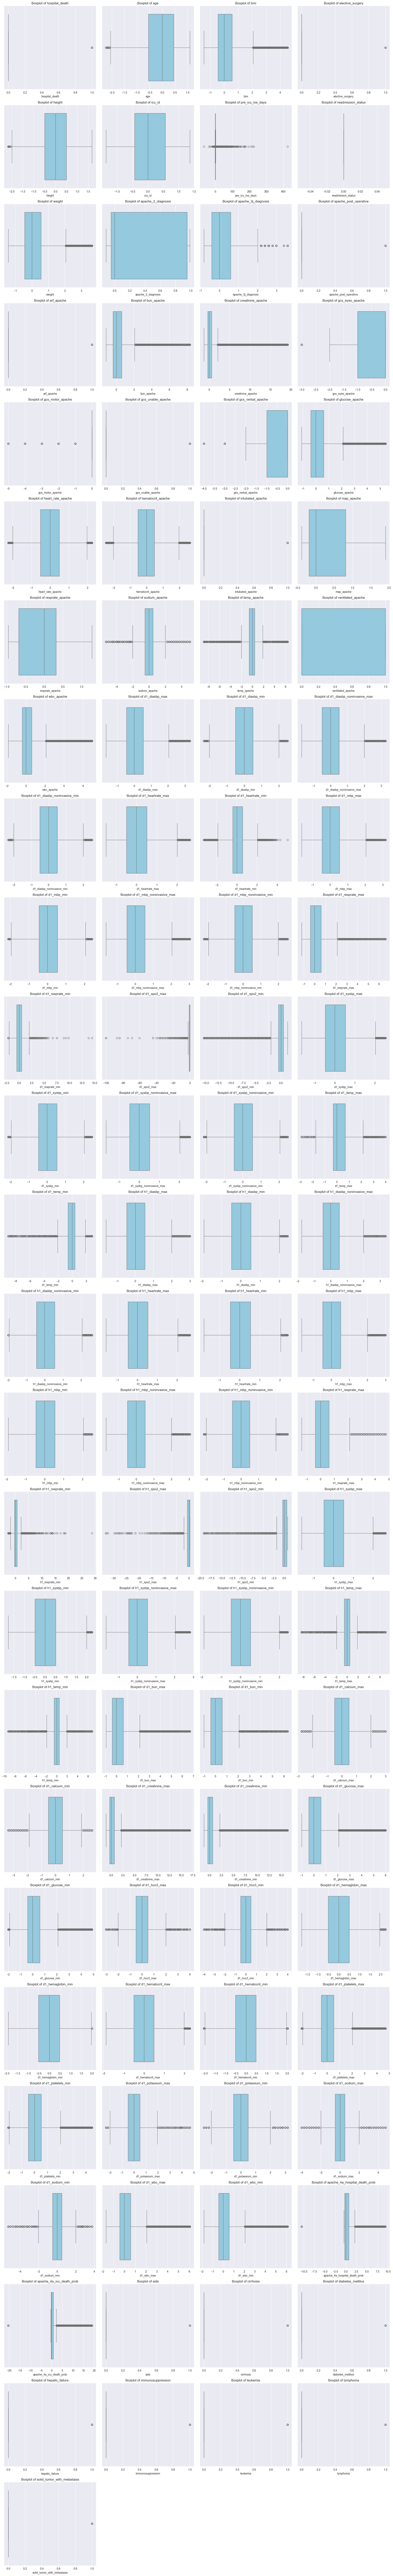

In [59]:
num_cols = len(numerical_columns)

cols = 4  
rows = (num_cols + cols - 1) // cols 

plt.figure(figsize=(20, rows * 5)) 

for i, column in enumerate(numerical_columns):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(x=scaled_imputed_df[column], color='skyblue')  
    plt.title(f'Boxplot of {column}')

plt.tight_layout()  

### Correlation Matrix

In [60]:
numeric_data = scaled_imputed_df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_data.corr()
corr_matrix[::-1]

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
solid_tumor_with_metastasis,-0.004608,-0.003022,-0.004804,0.050701,0.024983,-0.042417,0.015893,0.004877,-0.014295,0.036705,...,0.046586,0.027140,-0.001577,-0.005747,-0.012497,0.007369,0.269788,0.006305,0.014821,1.000000
lymphoma,-0.001162,0.002336,0.002537,0.018565,0.022796,-0.009658,-0.007969,0.008312,-0.002314,0.014024,...,0.017298,0.010661,0.021543,0.001579,-0.002053,0.001746,0.103271,0.031421,1.000000,0.014821
leukemia,-0.002153,0.000858,-0.003034,0.029554,0.029600,-0.013025,-0.017257,0.001711,0.001027,0.041798,...,0.042839,0.031052,-0.002452,-0.005290,0.003241,-0.001491,0.135024,1.000000,0.031421,0.006305
immunosuppression,-0.001678,0.000579,0.000040,0.043589,0.023907,-0.030527,-0.014071,0.000507,-0.030954,0.032888,...,0.037679,0.025460,0.025815,-0.002810,-0.001811,0.003230,1.000000,0.135024,0.103271,0.269788
hepatic_failure,-0.000952,-0.001637,0.001283,0.038554,-0.020665,-0.001742,-0.034242,0.010394,-0.011677,0.015248,...,0.022780,0.025514,0.003299,0.525958,0.011116,1.000000,0.003230,-0.001491,0.001746,0.007369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
age,-0.004013,0.006162,-0.008578,0.108306,1.000000,-0.086472,0.064523,-0.108982,-0.024056,0.048416,...,0.136165,0.073035,-0.029680,-0.028844,0.074723,-0.020665,0.023907,0.029600,0.022796,0.024983
hospital_death,-0.005243,0.004877,-0.001255,1.000000,0.108306,-0.031006,-0.093574,-0.019174,0.000994,0.063316,...,0.300259,0.274050,0.004354,0.039129,-0.016173,0.038554,0.043589,0.029554,0.018565,0.050701
hospital_id,-0.004532,-0.007075,1.000000,-0.001255,-0.008578,0.013358,0.052123,0.027657,0.004526,-0.001285,...,-0.006094,0.000218,-0.004946,0.002869,0.011572,0.001283,0.000040,-0.003034,0.002537,-0.004804
patient_id,-0.009575,1.000000,-0.007075,0.004877,0.006162,-0.001350,0.001387,0.002884,-0.001770,-0.004412,...,0.003626,0.001598,-0.002410,0.001328,0.000544,-0.001637,0.000579,0.000858,0.002336,-0.003022


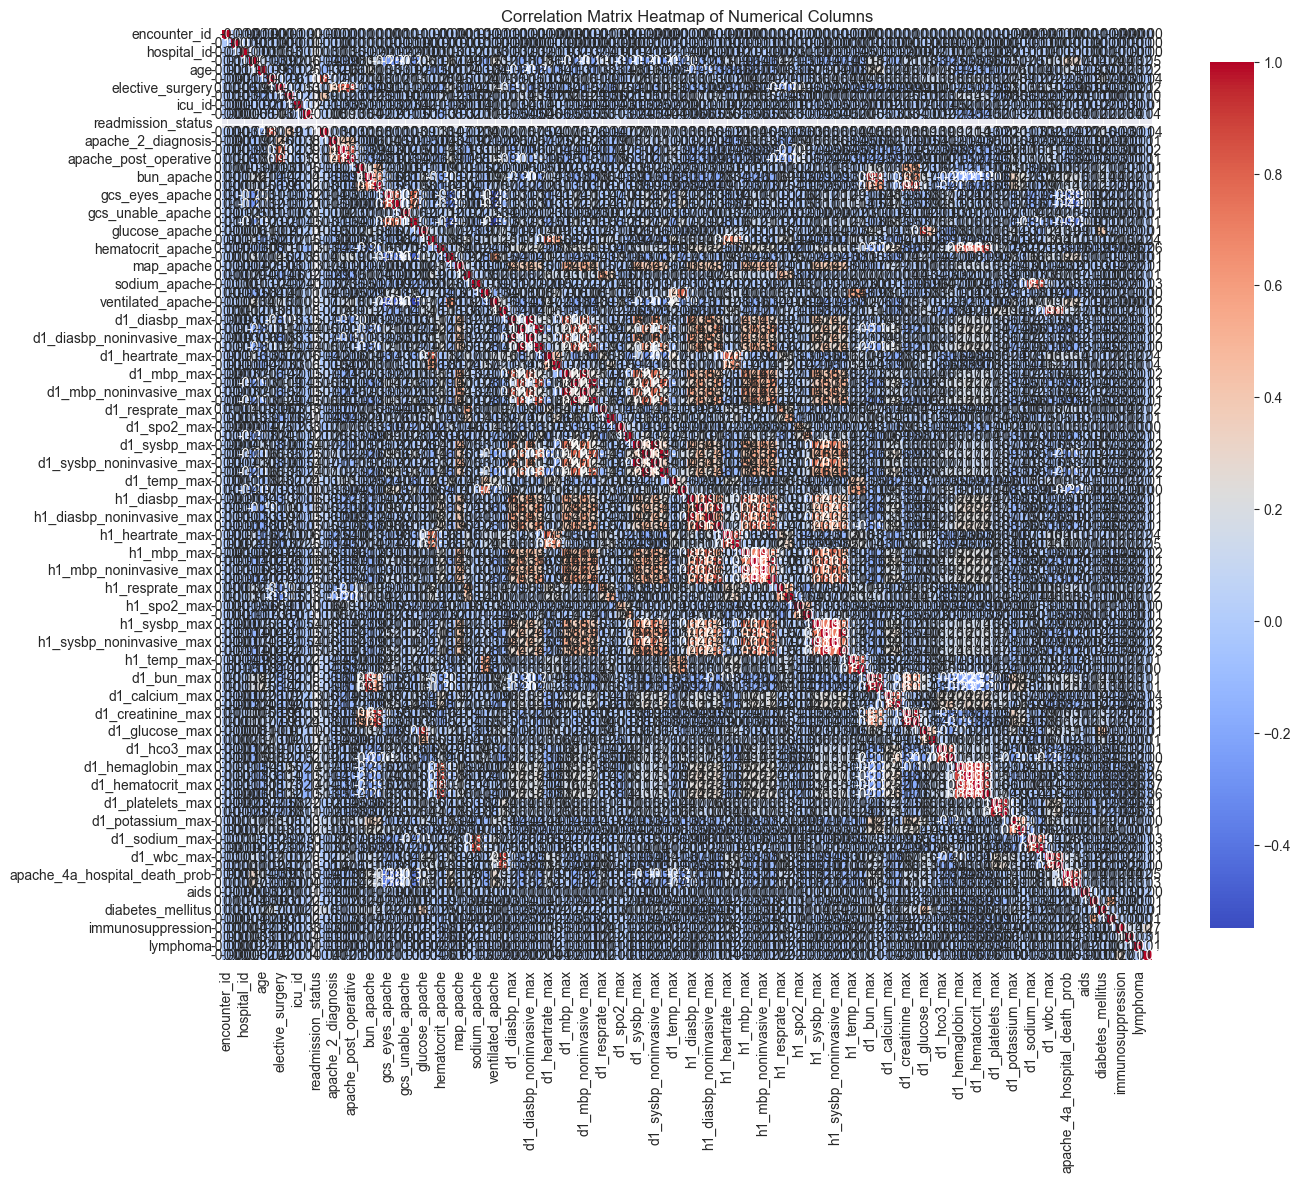

In [61]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'shrink': .75})
plt.title('Correlation Matrix Heatmap of Numerical Columns')
plt.show()

In [62]:
def get_highly_correlated_pairs(corr_matrix, threshold):
    pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):  # i+1 to exclude self-correlation
            if abs(corr_matrix.iloc[i, j]) > threshold:  # absolute value for both pos and neg correlations
                pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    
    pair_df = pd.DataFrame(pairs, columns=['Variable 1', 'Variable 2', 'Correlation'])
    pair_df = pair_df.sort_values(by='Correlation', ascending=False).reset_index(drop=True)
    return pair_df

high_corr_pairs = get_highly_correlated_pairs(corr_matrix, 0.5)
high_corr_pairs

,Variable 1,Variable 2,Correlation
0,d1_diasbp_min,d1_diasbp_noninvasive_min,0.993068
1,d1_diasbp_max,d1_diasbp_noninvasive_max,0.992785
2,d1_sysbp_min,d1_sysbp_noninvasive_min,0.992500
3,d1_sysbp_max,d1_sysbp_noninvasive_max,0.992223
4,d1_mbp_min,d1_mbp_noninvasive_min,0.990652
...,...,...,...
210,d1_mbp_min,h1_sysbp_noninvasive_min,0.513793
211,d1_mbp_noninvasive_min,h1_sysbp_min,0.512387
212,d1_temp_min,h1_temp_max,0.510956
213,arf_apache,d1_creatinine_max,0.507994


### Distributions

C:\Users\ozndn\AppData\Local\Temp\ipykernel_15536\1861082791.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hospital_death', y='age', data=scaled_imputed_df, ax=axes[0], palette=['green', 'red'])
C:\Users\ozndn\AppData\Local\Temp\ipykernel_15536\1861082791.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["Survived (0)", "Died (1)"])
C:\Users\ozndn\AppData\Local\Temp\ipykernel_15536\1861082791.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hospital_death', y='bmi', data=scaled_imputed_df, ax=axes[1], palette=['green', 'red'])
C:\Users\ozndn\AppData\Local\Temp\ipyk

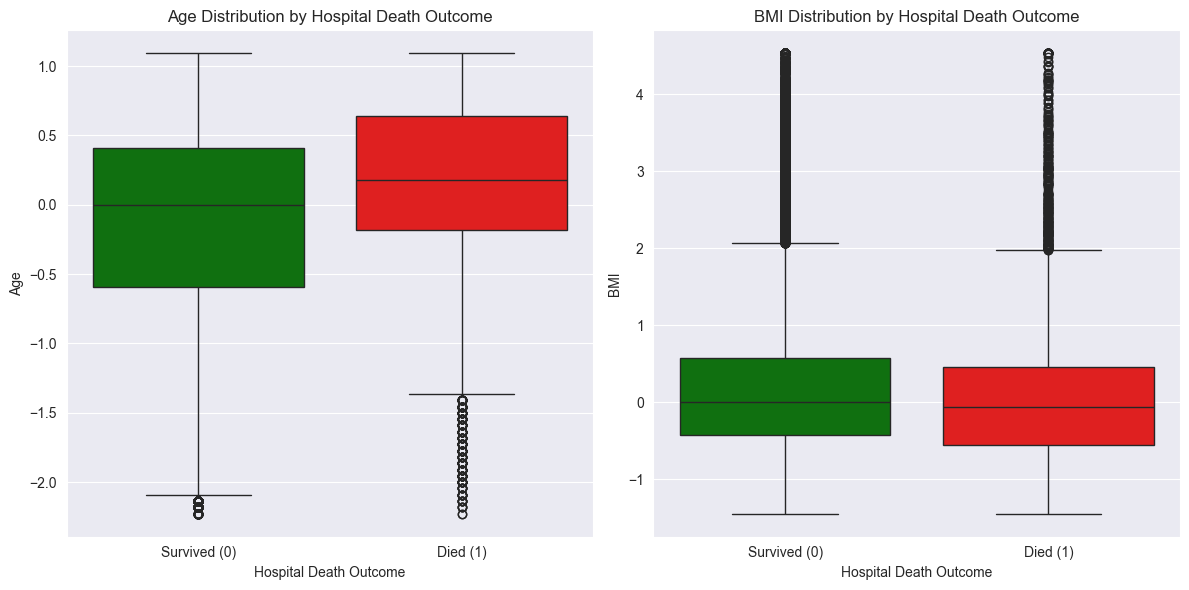

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Age vs Hospital Death
sns.boxplot(x='hospital_death', y='age', data=scaled_imputed_df, ax=axes[0], palette=['green', 'red'])
axes[0].set_title("Age Distribution by Hospital Death Outcome")
axes[0].set_xticklabels(["Survived (0)", "Died (1)"])
axes[0].set_xlabel("Hospital Death Outcome")
axes[0].set_ylabel("Age")

# BMI vs Hospital Death
sns.boxplot(x='hospital_death', y='bmi', data=scaled_imputed_df, ax=axes[1], palette=['green', 'red'])
axes[1].set_title("BMI Distribution by Hospital Death Outcome")
axes[1].set_xticklabels(["Survived (0)", "Died (1)"])
axes[1].set_xlabel("Hospital Death Outcome")
axes[1].set_ylabel("BMI")

plt.tight_layout()
plt.show()

C:\Users\ozndn\AppData\Local\Temp\ipykernel_15536\1421546230.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ethnicity_distribution.index, y=ethnicity_distribution.values, palette="viridis")


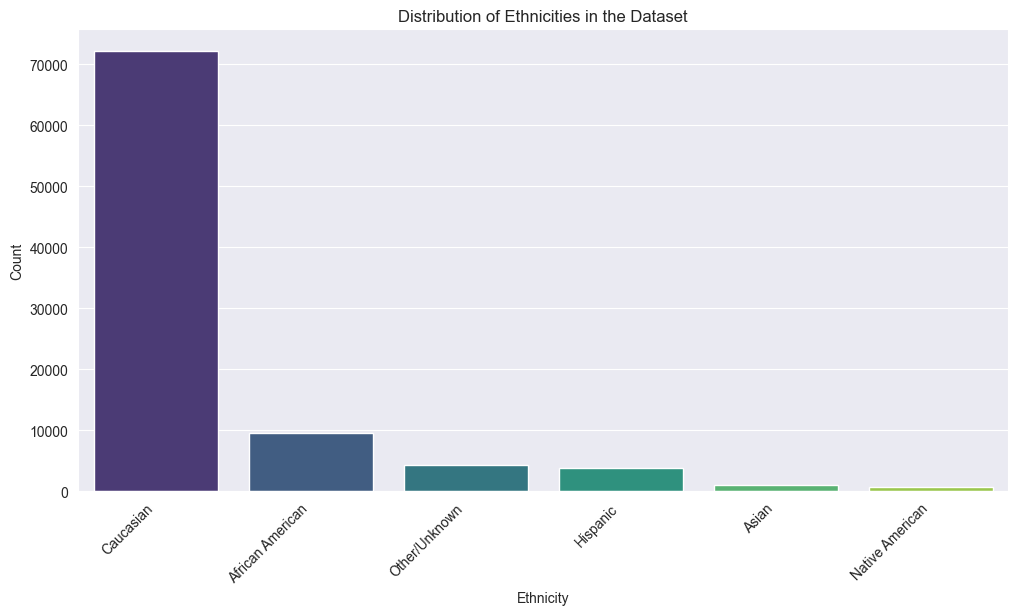

In [64]:
ethnicity_distribution = scaled_imputed_df['ethnicity'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=ethnicity_distribution.index, y=ethnicity_distribution.values, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Ethnicity")
plt.ylabel("Count")
plt.title("Distribution of Ethnicities in the Dataset")
plt.show()

C:\Users\ozndn\AppData\Local\Temp\ipykernel_15536\1951459101.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=ethnicity_death_counts.index, y=ethnicity_death_counts.values, palette="coolwarm")


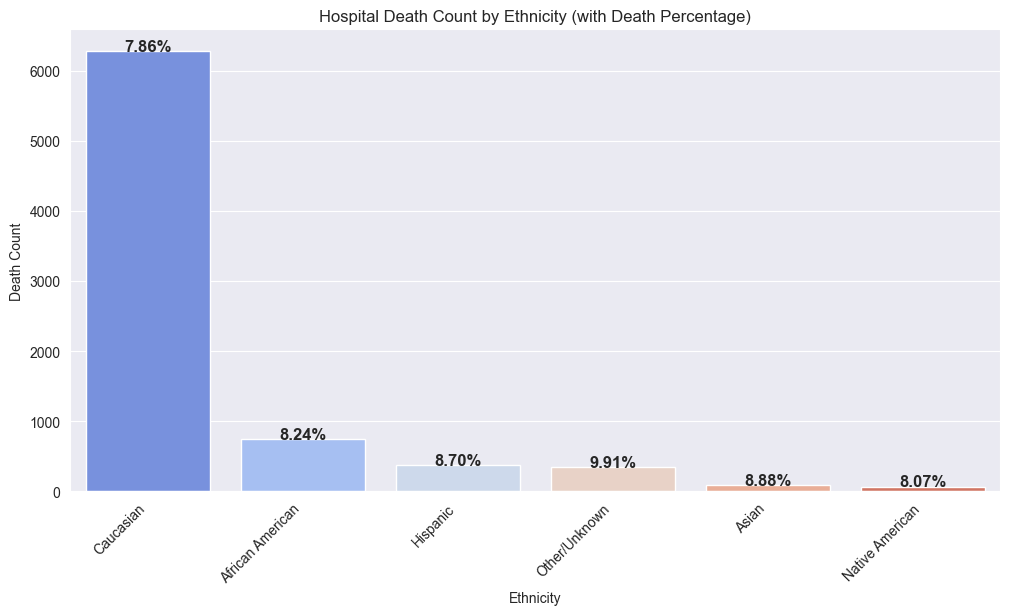

In [65]:
ethnicity_death_counts = scaled_imputed_df[scaled_imputed_df['hospital_death'] == 1]['ethnicity'].value_counts()
ethnicity_total_counts = scaled_imputed_df['ethnicity'].value_counts()
ethnicity_death_ratio = (ethnicity_death_counts / ethnicity_total_counts) * 100
ethnicity_death_ratio = (ethnicity_death_counts / ethnicity_total_counts * 100).fillna(0)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=ethnicity_death_counts.index, y=ethnicity_death_counts.values, palette="coolwarm")

for i, count in enumerate(ethnicity_death_counts.values):
    percentage = ethnicity_death_ratio.iloc[i]  
    ax.text(i, count + 2, f"{percentage:.2f}%", ha='center', fontsize=12, fontweight='bold')

plt.xticks(rotation=45, ha="right")
plt.xlabel("Ethnicity")
plt.ylabel("Death Count")
plt.title("Hospital Death Count by Ethnicity (with Death Percentage)")
plt.show()

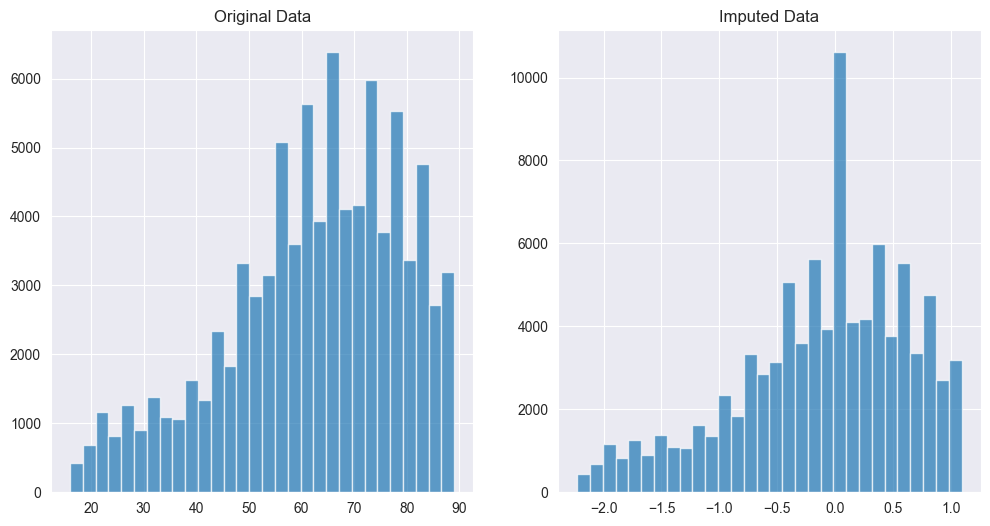

In [66]:
column = 'age'

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df[column].dropna().hist(bins=30, alpha=0.7)
plt.title('Original Data')

plt.subplot(1, 2, 2)
scaled_imputed_df[column].hist(bins=30, alpha=0.7)
plt.title('Imputed Data')

plt.show()

### Class Imbalance

In [67]:
class_counts = scaled_imputed_df['hospital_death'].value_counts()
class_percentages = scaled_imputed_df['hospital_death'].value_counts(normalize=True) * 100

print("Class Distribution (Raw Counts):")
print(class_counts)
print("\nClass Distribution (Percentage):")
print(class_percentages)

Class Distribution (Raw Counts):
hospital_death
0.0    83798
1.0     7915
Name: count, dtype: int64

Class Distribution (Percentage):
hospital_death
0.0    91.369817
1.0     8.630183
Name: proportion, dtype: float64


We might solve the class imbalance by using class weights

In [68]:
# Define the target variable
target_column = 'hospital_death'
classes = np.array([0, 1])

class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=scaled_imputed_df[target_column])
class_weight_dict = {classes[i]: class_weights[i] for i in range(len(classes))}


print("Computed Class Weights:", class_weight_dict)

Computed Class Weights: {np.int64(0): np.float64(0.5472266641208621), np.int64(1): np.float64(5.793619709412508)}


C:\Users\ozndn\AppData\Local\Temp\ipykernel_15536\3994166710.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_weight_dict.keys()), y=list(class_weight_dict.values()), palette='coolwarm')


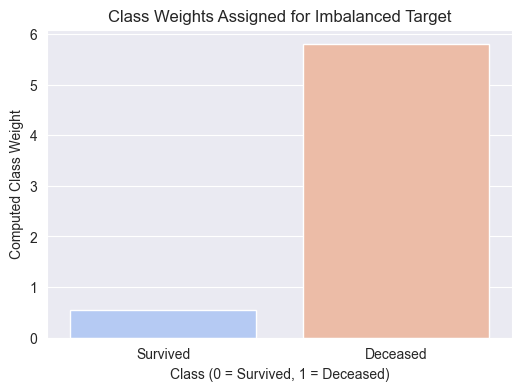

In [69]:
plt.figure(figsize=(6, 4))
sns.barplot(x=list(class_weight_dict.keys()), y=list(class_weight_dict.values()), palette='coolwarm')

plt.xlabel("Class (0 = Survived, 1 = Deceased)")
plt.ylabel("Computed Class Weight")
plt.title("Class Weights Assigned for Imbalanced Target")
plt.xticks(ticks=[0,1], labels=['Survived', 'Deceased'])

plt.show()